<a href="https://colab.research.google.com/github/CitricAmoeba/INT2-Group2/blob/main/CIFAR10_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [20]:
batch_size = 32

# Composition of several image transformations to perform on the training data
train_transform = transforms.Compose([
                                transforms.RandomCrop(32, 4),
                                transforms.RandomHorizontalFlip(),
                                transforms.ColorJitter(0.2, 0.2),
                                transforms.RandomAffine(10),
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.262))
                                ])

# Normalization mean and std calculated from: trainset.data.mean(axis=(0,1,2))/255 and trainset.data.std(axis=(0,1,2))/255


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2) # 50000 images

# Testing data normalization
test_transform = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.494, 0.485, 0.450), (0.247, 0.243, 0.261))
                                    ])
# Normalization mean and std calculated from: testset.data.mean(axis=(0,1,2))/255 and testset.data.std(axis=(0,1,2))/255

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2) # 10000 images

classes = trainset.classes # Categories of images

accuracy = []
avg_loss = []
lrs = []
#lr_loss = []

Files already downloaded and verified
Files already downloaded and verified


In [21]:
import torch.nn as nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 200, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(200, 256, 5)
        self.dropout1 = nn.Dropout2d(0.3)
        self.fc1 = nn.Linear(256 * 5 * 5, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)

        x = x.view(-1, 256 * 5 * 5)
        
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)

        x = self.fc3(x)

        return x


net = Net()
net.to(device)

print(net)

Using cuda device
Net(
  (conv1): Conv2d(3, 200, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(200, 256, kernel_size=(5, 5), stride=(1, 1))
  (dropout1): Dropout2d(p=0.3, inplace=False)
  (fc1): Linear(in_features=6400, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [22]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=1e-5)
# optimizer = torch.optim.AdamW(net.parameters(), lr=1e-3, amsgrad=True)
step_size = len(trainloader.dataset) // batch_size * 10
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-2, step_size_up=step_size, mode='triangular2')

# Use to determine base and max lr
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=5e-2, step_size_up=62500)

In [23]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        scheduler.step()
        lr = optimizer.param_groups[0]['lr']
        # lr_loss.append([lr, loss])
        lrs.append(lr)
        momentum = optimizer.param_groups[0]['momentum']
        
        if batch % (len(dataloader) // 5) == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}] lr: {lr:.8f} momentum: {momentum:.5f}")

In [24]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    accuracy.append(100*correct)
    avg_loss.append(test_loss)

In [25]:
epochs = 100

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(trainloader, net, loss_fn, optimizer)
    test(testloader, net)

print("Done!")

Epoch 1
-------------------------------
loss: 2.292148  [    0/50000] lr: 0.00001064 momentum: 0.89999
loss: 2.297155  [ 9984/50000] lr: 0.00021018 momentum: 0.89800
loss: 2.277154  [19968/50000] lr: 0.00040973 momentum: 0.89600
loss: 1.914681  [29952/50000] lr: 0.00060927 momentum: 0.89400
loss: 2.000022  [39936/50000] lr: 0.00080882 momentum: 0.89200
loss: 1.823144  [49920/50000] lr: 0.00100836 momentum: 0.89001
Test Error: 
 Accuracy: 36.8%, Avg loss: 0.055724 

Epoch 2
-------------------------------
loss: 1.691991  [    0/50000] lr: 0.00101028 momentum: 0.88999
loss: 1.745420  [ 9984/50000] lr: 0.00120982 momentum: 0.88799
loss: 1.485998  [19968/50000] lr: 0.00140937 momentum: 0.88599
loss: 1.589512  [29952/50000] lr: 0.00160891 momentum: 0.88399
loss: 1.685946  [39936/50000] lr: 0.00180846 momentum: 0.88200
loss: 1.460831  [49920/50000] lr: 0.00200800 momentum: 0.88000
Test Error: 
 Accuracy: 48.4%, Avg loss: 0.045365 

Epoch 3
-------------------------------
loss: 1.486446  [   

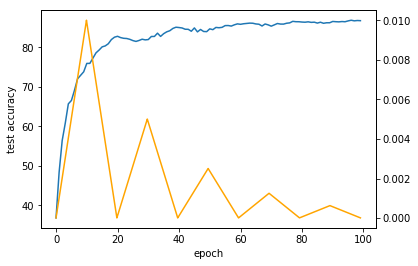

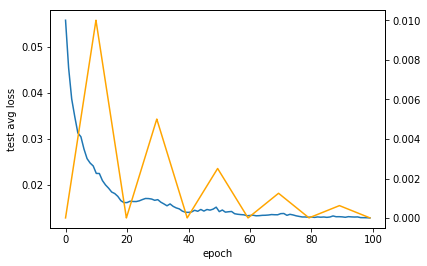

In [26]:
plt.xlabel('epoch')
plt.ylabel('test accuracy')
plt.plot(list(range(len(accuracy))), accuracy)
plt.twinx()
plt.twiny()
plt.xticks([])
plt.ylabel('learning rate')
plt.plot(list(range(len(lrs))), lrs, color='orange')

plt.figure()
plt.xlabel('epoch')
plt.ylabel('test avg loss')
plt.plot(list(range(len(avg_loss))), avg_loss)
plt.twinx()
plt.twiny()
plt.xticks([])
plt.ylabel('learning rate')
plt.plot(list(range(len(lrs))), lrs, color='orange')
plt.show()


In [27]:
# Plot learning rate against loss for cyclic lr parameter determination
# plt.xlabel('learning rate')
# plt.ylabel('loss')
# plt.ylim(0, 4)

#plt.plot(np.array(lr_loss)[:, 0], np.array(lr_loss)[:, 1])

In [28]:
# Calculate class breakdown of accuracy
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
confusion_matrix = torch.zeros(len(testset.classes), len(testset.classes))
with torch.no_grad():
    net.eval()
    for X, y in testloader:
        X, y = X.to(device), y.to(device)
        outputs = net(X)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == y).squeeze()
        for t, p in zip(y.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
        for i in range(16):
            label = y[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
for i in range(10):
    print(f'Accuracy of {classes[i]:10s} : {(100 * class_correct[i] / class_total[i]):.0f}%')

Accuracy of airplane   : 90%
Accuracy of automobile : 94%
Accuracy of bird       : 82%
Accuracy of cat        : 70%
Accuracy of deer       : 87%
Accuracy of dog        : 78%
Accuracy of frog       : 89%
Accuracy of horse      : 90%
Accuracy of ship       : 93%
Accuracy of truck      : 92%


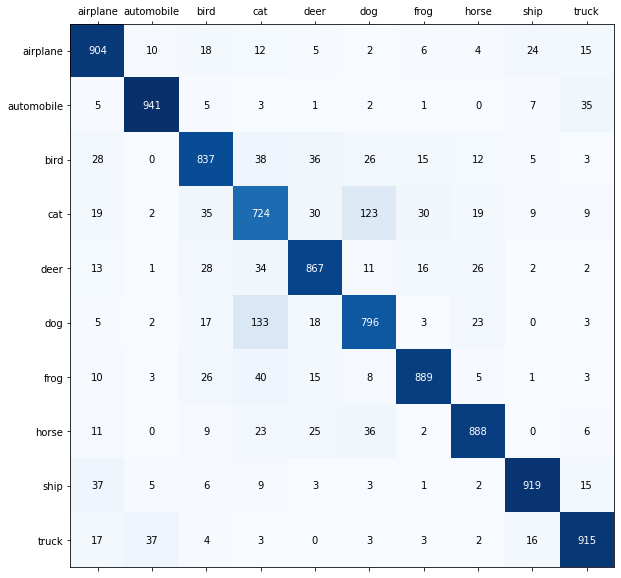

In [29]:
# Plot confusion matrix
fig, ax = plt.subplots()

ax.matshow(confusion_matrix, cmap=plt.cm.Blues)
fig.set_size_inches(10, 10)

plt.xticks(range(len(testset.classes)), testset.classes)
plt.yticks(range(len(testset.classes)), testset.classes)

for i in range(10):
    for j in range(10):
        c = confusion_matrix[j, i]
        ax.text(i, j, str(int(c)), va='center', ha='center', c='w' if c > 500 else 'k')
fig.savefig('confusion_matrix.png')
plt.show()

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:220: UserWarning: ONNX export failed on feature_dropout because training mode not supported
  warnings.warn("ONNX export failed on " + op + " because " + msg + " not supported")


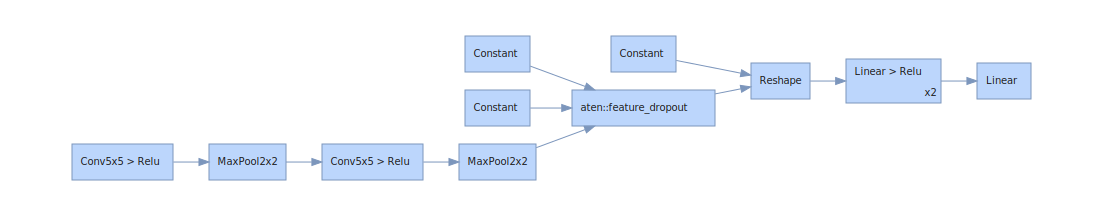

In [30]:
!pip install hiddenlayer
import hiddenlayer as hl

net.train()
hl_graph = hl.build_graph(net, torch.zeros([1, 3, 32, 32]).to(device))
hl_graph.theme = hl.graph.THEMES["blue"].copy()
hl_graph